In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from matplotlib import pyplot

## Game  by game describtion of home team/ visiter team wins 

In [2]:
mainData = pd.read_csv("game_logs.csv")

C:\Users\amjad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12,13,14,15,19,20,81,83,85,87,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
mainData.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,5,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,6,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,7,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,2,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,3,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


In [4]:
df = mainData[['date', 'day_of_week','v_game_number','h_game_number', 'v_score','h_score','day_night',
               'attendance','length_minutes']].copy()

In [5]:
df.shape

(171907, 9)

In [6]:
df.dtypes

date                int64
day_of_week         int64
v_game_number       int64
h_game_number       int64
v_score             int64
h_score             int64
day_night          object
attendance        float64
length_minutes    float64
dtype: object

In [7]:
# change date into datetime
# doing this step create a problem that it makes the data not fitted for the transformer! it make it 3d
#df['date'] = datetime.strptime('18710504', '%Y%m%d')
df['day_night'] = df['day_night'].replace(['D','N'],[1,0])

In [8]:
df[['day_night']]

,day_night
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
171902,1.0
171903,1.0
171904,1.0
171905,1.0


In [9]:
# calculate which column is greater than the other then if the visiting team win v=1, if the home team win h=0
df['visit_win'] = np.where(
    df['v_score'] > df['h_score'], 1, 0)

In [10]:
df[['visit_win']]

,visit_win
0,0
1,1
2,1
3,0
4,1
...,...
171902,1
171903,1
171904,1
171905,0


In [11]:
win=df['visit_win'].value_counts()

### - Detect impalance dataset

<AxesSubplot:>

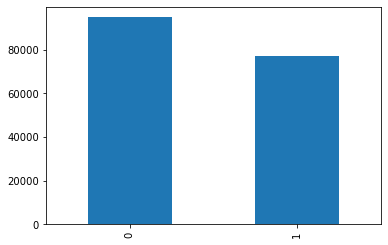

In [12]:
win.plot(kind='bar')

In [13]:
df = df.replace([' ','NULL','na','(none)'],np.nan)

### - Acoording the analysis we detict a big gab in the score before 1960

In [14]:
df_2 = df[df["date"] > 19600411]

In [24]:
# drop any NaNs
df_3 = df_2.dropna()

In [25]:
df_3.shape

(77594, 10)

In [26]:
df_3.dtypes

date                int64
day_of_week         int64
v_game_number       int64
h_game_number       int64
v_score             int64
h_score             int64
day_night         float64
attendance        float64
length_minutes    float64
visit_win           int32
dtype: object

In [27]:
# drop date feature
df_4 = df_3.drop(['date'],axis=1)

## Modeling

- Deleted Linear Support Vector Classifier (SVC) because it took forever to run 
- Deleted Logistic Regression model because it could not predict 1 at all.

In [30]:
#ML model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [31]:
#VS
from yellowbrick.classifier import classification_report, confusion_matrix, discrimination_threshold

In [28]:
scale= StandardScaler()

In [29]:
scale.fit(df_4)

StandardScaler()

In [33]:
features = df_4[[
    'day_of_week','v_game_number','h_game_number'
    ,'attendance','length_minutes', 'day_night']]

target = df_4[['visit_win']].values.ravel()

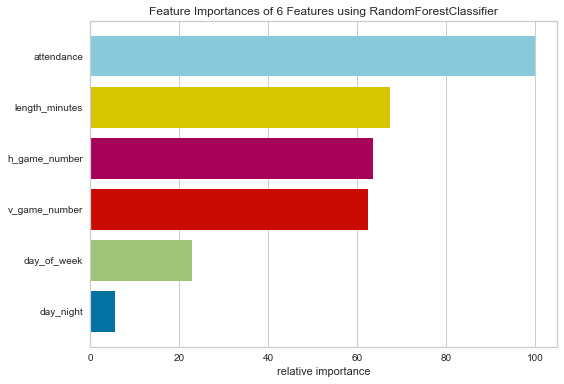

<AxesSubplot:title={'center':'Feature Importances of 6 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [34]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model)
viz.fit(features, target)
viz.show()

In [35]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2
)

In [36]:
X_train.shape

(62075, 6)

In [37]:
y_train.shape

(62075,)

## Gaussian Naive Bayes model 

In [38]:
# Taking the best seven features and applying them to different ML models
cross_validate(GaussianNB(), X_train, y_train, cv=TimeSeriesSplit(), scoring='f1_macro')

{'fit_time': array([0.01385403, 0.01601839, 0.01893592, 0.02292299, 0.02690959]),
 'score_time': array([0.01295733, 0.01096177, 0.01096368, 0.01101208, 0.01196027]),
 'test_score': array([0.53134194, 0.52169548, 0.51472413, 0.52666303, 0.50581607])}

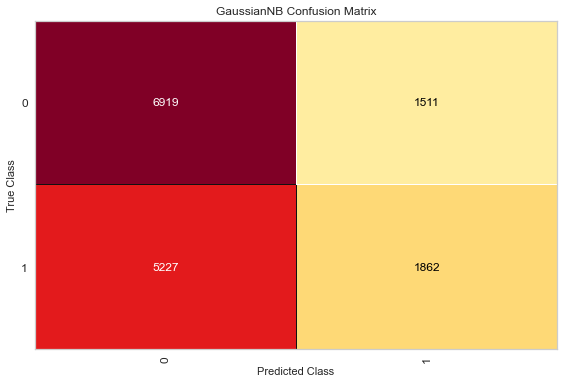

ConfusionMatrix(ax=<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000014463BED3A0>,
                estimator=GaussianNB(), is_fitted=False)

In [39]:
confusion_matrix(GaussianNB(), X_train, y_train, X_test, y_test, is_fitted=False)

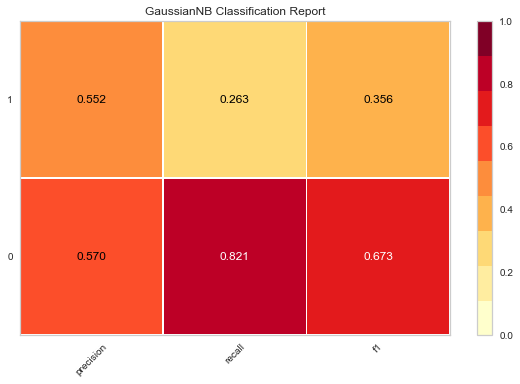

ClassificationReport(ax=<AxesSubplot:title={'center':'GaussianNB Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000014465E366A0>,
                     estimator=GaussianNB(), is_fitted=False)

In [40]:
classification_report(GaussianNB(), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

 ## K nearest neighbors classifier

In [43]:
cross_validate(KNeighborsClassifier(n_neighbors=5), X_train, y_train,
               scoring='f1_macro')

{'fit_time': array([0.24944639, 0.2951622 , 0.26628685, 0.27929997, 0.28427958]),
 'score_time': array([0.68023252, 0.77571726, 0.7707231 , 0.76357794, 0.76521754]),
 'test_score': array([0.51799217, 0.52045937, 0.52370382, 0.51797609, 0.51646654])}

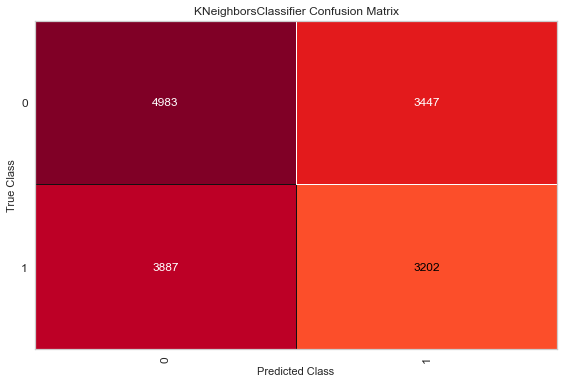

ConfusionMatrix(ax=<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x00000144666FD970>,
                estimator=KNeighborsClassifier(), is_fitted=False)

In [42]:
confusion_matrix(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test, is_fitted=False)

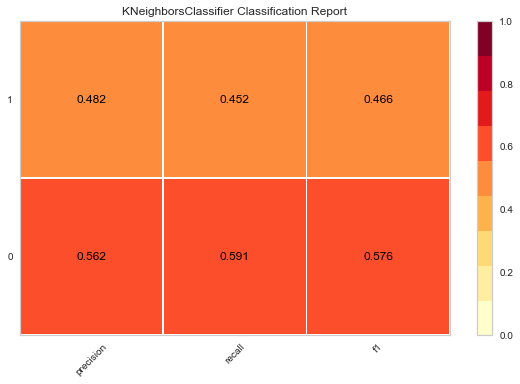

ClassificationReport(ax=<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x000001446671A2E0>,
                     estimator=KNeighborsClassifier(), is_fitted=False)

In [44]:
classification_report(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test,scoring='f1_macro', is_fitted=False)

# Conclusion

- Though the K nearest neighbors classifier and Gaussian Naive Bayes model have the best scores around 5, when we look at the proficiency visualization we find out that Gaussian Naive Bayes does better. 
- Gaussian Naive Bayes model predicted false positives (positive that is actually negative) more accurately than K nearest neighbors classifier. The second model gives 0.4 percentage on labeling an instance 1 that is actually 0. Which indicates that it can't be reliable in that matter.
- Recall shows a significant difference in these two models too. Gaussian Naive Bayes model predicted true positive 0 better by 0.8, while K nearest neighbors classifier is 0.5. However, the Gaussian Naive Bayes model predicted true positive 1 less precisely by 0.2, while K nearest neighbors classifier got a better score by 0.5
- The balance between the precision and the recall which is F1 score indicates that Gaussian Naive Bayes model accuracy is o.3 in 1 and 0.6 in 0, while K nearest neighbors classifier accuracy is 0.4 in 1 and 0.5 in 0. 
- In the end, the question is which result matter to you, is it predicting positive as positive or negative as negative to choose between the two models.